In [1]:
import numpy as np
import hapke
import matplotlib.pyplot as plt
from scipy import optimize
import os
import shutil
from pyvims import VIMS

In [2]:
# DOWNLOAD THE CUBE AND ALLOCATE IT TO THE RIGHT FOLDER

cube_id = '1671591682_1'

directory = 'C:/Users/USUARIO/Desktop/MSc Thesis/Phase A - Data Analysis/Data/'
cube = VIMS(cube_id,root=directory)

origin = directory + cube.fname
destination = directory + cube.target_name + '/' + str(cube.flyby)

# If the folder does not exist, create it

if not os.path.exists(destination):
    os.mkdir(destination)
    print("New folder created")

if os.path.exists(destination + '/' + cube.fname):
    print("Existing Cube")
else:
    shutil.move(origin, destination)

print("Cube saved in: " + destination)


Existing Cube
Cube saved in: C:/Users/USUARIO/Desktop/MSc Thesis/Phase A - Data Analysis/Data/ENCELADUS/E13


In [3]:
T = 80

n = hapke.opticalconstants(T)['n']
k = hapke.opticalconstants(T)['k']
wav = hapke.opticalconstants(T)['wav']

n2 = hapke.opticalconstants(T,crystallinity=False)['n']
k2 = hapke.opticalconstants(T,crystallinity=False)['k']
wav2 = hapke.opticalconstants(T,crystallinity=False)['wav']

int_opt = hapke.inter_optical_constants(wav, wav2, n, k)

wav = int_opt['wav']
n = int_opt['n']
k = int_opt['k']

In [4]:
pixel1 = cube@(36, 15)
e, i, phase = [np.deg2rad(pixel1.eme),np.deg2rad(pixel1.inc),np.deg2rad(pixel1.phase)]

angles = [e,i,phase]

IF1 = pixel1.spectrum
wav1 = pixel1.wvlns
ini_par = [0.30, 0.00001, np.deg2rad(20)]

optimized_parameters = optimize.least_squares(
    hapke.cost_function, ini_par, args=(wav, angles, IF1, wav1,n,k), bounds=([0.0,0.0,0.0], [0.75,0.001,np.deg2rad(45)], ), x_scale='jac'
)

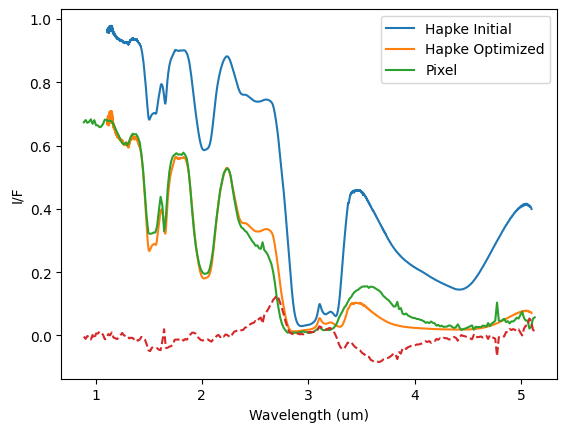

In [5]:
optimized_values = optimized_parameters.x

old_hapke = hapke.hapke_model(ini_par,wav, angles, n,k)['IF']

new_hapke = hapke.hapke_model(optimized_parameters.x,wav,angles, n,k)['IF']

fig, ax = plt.subplots()
ax.plot(wav, old_hapke, label = 'Hapke Initial')
ax.plot(wav, new_hapke, label = 'Hapke Optimized')
ax.plot(wav1, IF1, label = 'Pixel')
ax.plot(wav1, optimized_parameters.fun, ls = '--')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('I/F')
ax.set_title('')
ax.legend()
plt.show()

In [11]:
optimized_values = optimized_parameters.x

# Retrieve the covariance matrix
cov_matrix = np.linalg.inv(optimized_parameters.jac.T @ optimized_parameters.jac)

# Calculate the standard errors of the optimized parameters
parameter_errors = np.sqrt(np.diag(cov_matrix))

# Print the optimized parameter values and their errors
for i, value in enumerate(optimized_values):
    print(f"Parameter {i+1}: {value:} +/- {parameter_errors[i]:.4f}")

# Calculate correlation matrix
correlation_matrix = cov_matrix / np.outer(parameter_errors, parameter_errors)

print("Correlation matrix:")
print(correlation_matrix)

Parameter 1: 0.0006443578194693789 +/- 0.2786
Parameter 2: 4.781472429826851e-05 +/- 0.0001
Parameter 3: 5.1492444527907744e-08 +/- 10463734.8667
Correlation matrix:
[[1.         0.928771   0.98295876]
 [0.928771   1.         0.88353334]
 [0.98295876 0.88353334 1.        ]]


In [6]:
ini_par = [0.30, 0.00001, np.deg2rad(20), 0.3]

optimized_parameters_mixed = optimize.least_squares(
    hapke.cost_function_mixed, ini_par, args=(wav, angles, IF1, wav1,n,k,n2,k2), bounds=([0.0,0.0,0.0,0.0], [0.75,0.001,np.deg2rad(45),1.0]), x_scale='jac'
)

In [7]:
optimized_values_mixed = optimized_parameters_mixed.x

# Retrieve the covariance matrix
cov_matrix = np.linalg.inv(optimized_parameters_mixed.jac.T @ optimized_parameters_mixed.jac)

# Calculate the standard errors of the optimized parameters
parameter_errors = np.sqrt(np.diag(cov_matrix))

# Print the optimized parameter values and their errors
for i, value in enumerate(optimized_values_mixed):
    print(f"Parameter {i+1}: {value:} +/- {parameter_errors[i]:.4f}")

# Calculate correlation matrix
correlation_matrix = cov_matrix / np.outer(parameter_errors, parameter_errors)

print("Correlation matrix:")
print(correlation_matrix)

Parameter 1: 0.0019220923083702944 +/- 0.2602
Parameter 2: 4.869733056254785e-05 +/- 0.0001
Parameter 3: 2.0648255731795477e-08 +/- 11934223.8155
Parameter 4: 0.5348680725186781 +/- 1.4226
Correlation matrix:
[[1.         0.86203738 0.95116003 0.10901232]
 [0.86203738 1.         0.76467415 0.21764108]
 [0.95116003 0.76467415 1.         0.08562267]
 [0.10901232 0.21764108 0.08562267 1.        ]]


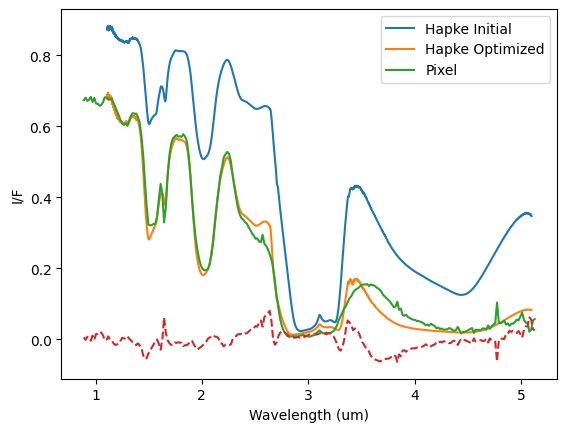

In [8]:
optimized_values_mixed = optimized_parameters_mixed.x

old_hapke = hapke.hapke_model_mixed(ini_par,wav, angles, n,k,n2,k2)['IF']

new_hapke = hapke.hapke_model_mixed(optimized_parameters_mixed.x,wav,angles, n,k,n2,k2)['IF']

fig, ax = plt.subplots()
ax.plot(wav, old_hapke, label = 'Hapke Initial')
ax.plot(wav, new_hapke, label = 'Hapke Optimized')
ax.plot(wav1, IF1, label = 'Pixel')
ax.plot(wav1, optimized_parameters_mixed.fun, ls = '--')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('I/F')
ax.set_title('')
ax.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

plt.imshow(cube@2.03, extent=cube.extent, cmap='gray', vmin=0, vmax=.18)

plt.colorbar(extend='max', label='I/F')

plt.scatter(36, 15, s=150)
plt.scatter(27, 30, s=150)

plt.xlabel(cube.slabel)
plt.ylabel(cube.llabel)

plt.xticks(cube.sticks)
plt.yticks(cube.lticks);

In [ ]:
pixel1 = cube@(27, 30)

i = np.deg2rad(pixel1.inc)
e = np.deg2rad(pixel1.eme)
g = np.deg2rad(pixel1.phase)

print(pixel1.inc,pixel1.eme,pixel1.phase)

IF1 = pixel1.spectrum
wav1 = pixel1.wvlns

gamma = np.arctan((np.cos(i))/(np.cos(e)*np.sin(g)) - 1 / np.tan(g))
beta = np.cos(e)/np.cos(gamma)

disk_f = np.cos(g/2)*np.cos((np.pi/(np.pi-g))*(gamma-g/2))*beta**(g/(np.pi-g))/np.cos(gamma)
albedo = IF1/(disk_f*(1-0.3651*g))



ini_par = [0.30, 0.00001, np.deg2rad(20)]

optimized_parameters = optimize.least_squares(
    cost_function, ini_par, args=(wavelength_range1, e, i, g, IF1, wav1), bounds=([0.0,0.0,0.0], [0.75,0.0001,np.deg2rad(45)])
)

In [ ]:
print(optimized_parameters)
optimized_values = optimized_parameters.x
new_hapke = hapke_model(optimized_parameters.x,wavelength_range1,e,i,g)

fig, ax = plt.subplots()
ax.plot(wavelength_range1, hapke_model(ini_par,wavelength_range1,e,i,g), label = 'Hapke Initial')
ax.plot(wavelength_range1, new_hapke, label = 'Hapke Optimized')
ax.plot(wav1, IF1, label = 'Pixel')
ax.plot(wav1, optimized_parameters.fun, ls = '--')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('I/F')
ax.set_title('')
ax.legend()
plt.show()

In [ ]:
optimized_values = optimized_parameters.x

# Retrieve the covariance matrix
cov_matrix = np.linalg.inv(optimized_parameters.jac.T @ optimized_parameters.jac)

# Calculate the standard errors of the optimized parameters
parameter_errors = np.sqrt(np.diag(cov_matrix))

# Print the optimized parameter values and their errors
for i, value in enumerate(optimized_values):
    print(f"Parameter {i+1}: {value:} +/- {parameter_errors[i]:.4f}")

correlation_matrix = cov_matrix / np.outer(parameter_errors, parameter_errors)

print("Correlation matrix:")
print(correlation_matrix)